In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, Lambda, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as K
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import classification_report, confusion_matrix
import cv2

import itertools
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pydot
from IPython.display import SVG

In [3]:
def getimages(direct):
    im=[]
    label=[]
    lab=0
    for labels in os.listdir(direct):
        #Label corresponding to folder
        if labels=="buildings":
            lab=0
        if labels=="forest":
            lab=1
        if labels=="glacier":
            lab=2
        if labels=="mountain":
            lab=3
        if labels=="sea":
            lab=4
        if labels=="street":
            lab=5
        for image in os.listdir(direct+r'/'+labels):
            #Read images
            imag=cv2.imread(direct+r'/'+labels+r'/'+image)
            imag=cv2.resize(imag,(150,150))
            
            im.append(imag)
            label.append(lab)
    #Suffle all images
    return shuffle(im, label)

#Obtain both train and test images
im,label=getimages("archive\seg_train\seg_train")      
im1,label1=getimages("archive\seg_test\seg_test") 
img=im+im1
lab=label+label1

#Convert to numpy array
Images=np.array(img)
Labels=np.array(lab)

classes=6

In [6]:
#Split into train, validation and test
x1, xtest, y1,ytest=train_test_split(Images, Labels, random_state=0)
xtrain, xvalidation, ytrain, yvalidation=train_test_split(x1, y1, random_state=0)

#Prepare x
xtrain = xtrain.astype('float32')
xvalidation = xvalidation.astype('float32')
xtest=xtest.astype('float32')
xtrain /= 255
xvalidation /= 255
xtest /= 255


#Prepare y
ytrain0 = keras.utils.to_categorical(ytrain, classes)
yvalidation0 = keras.utils.to_categorical(yvalidation, classes)
ytest0=keras.utils.to_categorical(ytest, classes)

In [33]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    
    
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)

    # classification layers
    return layer_out

In [81]:
im_Input = Input(shape=(xtrain.shape[1:]), name="input")
Inception = inception_module(im_Input, 64, 96, 128, 16, 32, 32)
#Inception = inception_module(Inception, 128, 128, 192, 32, 96, 64)


In [82]:
Inception = Flatten()(Inception)
#Inception = Dense(512, activation='relu')(Inception)
Inception = Dropout(0.5)(Inception)
Inception = Dense(classes, activation='softmax')(Inception)

In [83]:
baseModel = Model(im_Input, Inception)

# compile
baseModel.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [9]:
# get the newest model file within a directory
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model

In [10]:
# make saving directory for checkpoints
baseSaveDir = "./Incep_base_Im/"
if not os.path.isdir(baseSaveDir):
    os.makedirs(baseSaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(baseSaveDir, 'Incep_base_Im.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data from the directory if exists
baseModel = getNewestModel(baseModel, baseSaveDir)

In [84]:
# Number of training/testing examples per batch
batch_size = 50

# Training epochs. 
epochs = 10

# train
history=baseModel.fit(xtrain, ytrain0,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(xvalidation, yvalidation0),
               callbacks=[es_cb,cp_cb])

Epoch 1/10
192/192 [==============================] - ETA: 0s - loss: 16.2499 - accuracy: 0.4701
Epoch 00001: val_loss improved from inf to 3.13766, saving model to ./Incep_base_Im\Incep_base_Im.01-3.14.hdf5
192/192 [==============================] - 1477s 8s/step - loss: 16.2499 - accuracy: 0.4701 - val_loss: 3.1377 - val_accuracy: 0.5564
Epoch 2/10
192/192 [==============================] - ETA: 0s - loss: 2.0384 - accuracy: 0.6334
Epoch 00002: val_loss improved from 3.13766 to 1.16166, saving model to ./Incep_base_Im\Incep_base_Im.02-1.16.hdf5
192/192 [==============================] - 1718s 9s/step - loss: 2.0384 - accuracy: 0.6334 - val_loss: 1.1617 - val_accuracy: 0.6772
Epoch 3/10
192/192 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.7964
Epoch 00003: val_loss improved from 1.16166 to 1.15317, saving model to ./Incep_base_Im\Incep_base_Im.03-1.15.hdf5
192/192 [==============================] - 1891s 10s/step - loss: 0.6477 - accuracy: 0.7964 - val_loss:

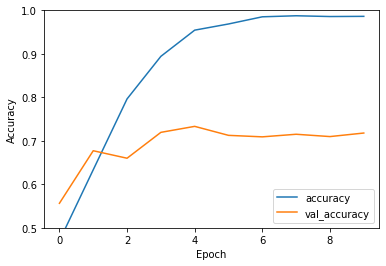

In [85]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [15]:
ytrain0.shape

(9581, 6)

In [20]:
xtrain.shape[1:]

(150, 150, 3)

In [73]:
baseModel.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 150, 150, 96) 384         input[0][0]                      
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 150, 150, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 150, 150, 3)  0           input[0][0]                      
______________________________________________________________________________________